In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
import matplotlib.pyplot as plt
from scipy import interpolate, optimize

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, u, u_x) \ dx  = \int_{\Omega \subset \mathbb{R}}(u(x)-f_0(x))^2 + \alpha \ \Psi_1(u(x)-f_0(x)) + \beta \ \Psi_2(|u_x(x)|) \ dx $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} =  2(u(x)-f_0(x)) + \alpha \ \Psi_1'(u(x)-f_0(x)) - \beta \ u_{xx}(x) \ \Psi_2''(|u_{x}(x)|) = 0$$

whit boundary condition $u(\partial \Omega) = 0$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x) = \sum_{i=1}^N c_i \ \phi(x; x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2}{2 \sigma_i^2}}$$

In [7]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
cont.load('../../bindata/fits/cubes/M100line.image.fits')
#cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.data

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


In [14]:
"""
Generating the data function
"""
f_data = data[:,300,300]
x = np.linspace(0., 1., len(f_data), endpoint=True)
f = sp.interpolate.interp1d(x, f_data, kind='linear')
x_ = np.linspace(0., 1., 10*len(f_data), endpoint=True)

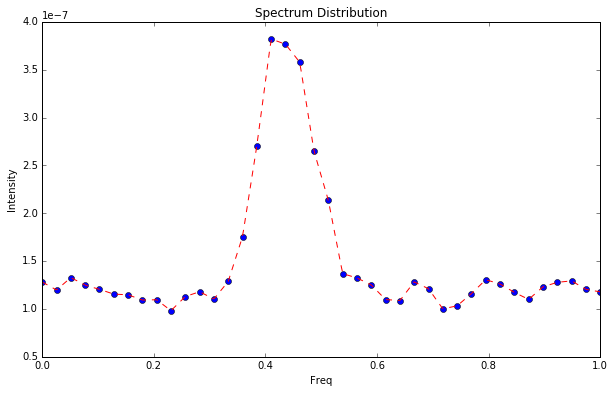

In [16]:
plt.figure(figsize=(10,6))
plt.plot(x, f_data, 'bo', x_, f(x_), 'r--')
plt.title('Spectrum Distribution')
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.show()

In [17]:
#setting parameters
a = 0.001*0
b = 0.1*0
N = 3

z = sym.Symbol('z')

#Penalizing function and its derivatives
psi1 = sym.exp(z)
d1psi1 = sym.diff(psi1, z)
d1psi1 = sym.lambdify(z, d1psi1, modules='numpy')

#Smoothing function and its derivatives
lamb = 0.5
#psi2 = 2*lamb*sym.log(1 + z**2/lamb)
psi2 = z**3
d1psi2 = sym.diff(psi2, z)
d2psi2 = sym.diff(d1psi2, z)
d1psi2 = sym.lambdify(z, d1psi2, modules='numpy')
d2psi2 = sym.lambdify(z, d2psi2, modules='numpy')

In [18]:
"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, sig):
    retval = ne.evaluate('exp(-x**2/(2*sig**2))')
    #retval = np.exp(-x**2/(2*sig**2))
    return retval

def phix(x, sig):
    retval = ne.evaluate('-(1./sig**2) * exp(-x**2/(2*sig**2)) * x')
    #retval = -(1./sig**2) * np.exp(-x**2/(2*sig**2)) * x
    return retval

def phixx(x, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-x**2/(2*sig**2)) * (x**2 - sig**2)')
    #retval = (1./sig**4) * np.exp(-x**2/(2*sig**2)) * (x**2 - sig**2)
    return retval

In [19]:
""" Computing collocation points """
xc = np.linspace(0., 1., N+1)[1::]-(1./(2.*N))
print(xc)

""" Computing evaluation points """
xe = np.linspace(0., 1., 2*N, endpoint=True)
print(xe)

""" Computing the values of f at evaluation points """
f0 = f(xe)

""" 
Computing distance matrix.
Note: Evaluation and collocation points will be the same
"""
Dx = np.empty((2*N,N))
for k in range(2*N):
	Dx[k,:] = (xe[k] - xc)

[ 0.16666667  0.5         0.83333333]
[ 0.   0.2  0.4  0.6  0.8  1. ]


In [8]:
def F(X):
    #unpacking parameters
    N = len(X)/2
    c = X[0:N]
    sig = X[N:]
    
    #quiting borders
    _Dx = Dx[1:-1]
    _f0 = f0[1:-1]
    
    #phi function's evaluation
    phi_m   = phi(_Dx, sig)
    phix_m  = phix(_Dx, sig)
    phixx_m = phixx(_Dx, sig)
    
    #computing the Euler-Lagrange equation
    u   = np.dot(phi_m, c)
    ux  = np.dot(phix_m, c)
    uxx = np.dot(phixx_m, c)
    el = 2.*(u-_f0) + a*d1psi1(u-_f0) - b*uxx*d2psi2(np.abs(ux))
    
    #evaluating at boundary
    bc = [np.dot(phix(-xc,sig),c), np.dot(phix(1.-xc,sig),c)]
    return 10**7*np.concatenate([el,bc])

In [9]:
"""
Defining initial parameter values
"""
c0 = f(xc)/N
sig0 = (1./(N))*np.ones(N)
X0 = np.concatenate([c0,sig0])

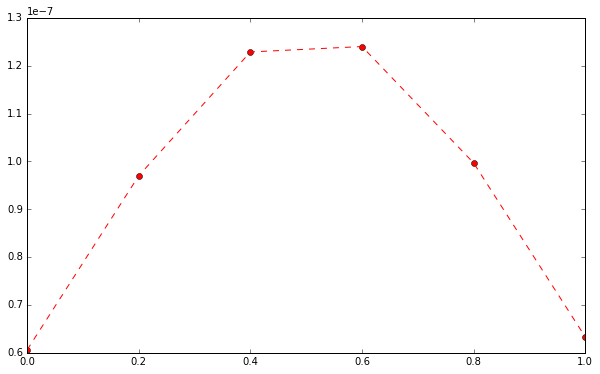

In [10]:
"""
Visualizing the 'initial' solution
"""
phi_m0 = phi(Dx, sig0)
u0 = np.dot(phi_m0, c0)
plt.figure(figsize=(10,6))
plt.plot(xe, u0, 'ro', xe, u0, 'r--')
plt.show()

In [11]:
"""
Solve it!
"""
res = sp.optimize.fsolve(F, X0, full_output=True)
X = res[0]
c = X[0:N]
sig = X[N:]
#print("c coeficients:"); print(c)
#print('sigmas:'); print(sig)
print(res[1]['nfev']); print(res[3])
print(sig); print(1./N)
print(c)

58
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
[-6.73263466  6.88479242  6.71789041]
0.333333333333
[  1.64906395e-06  -1.90958437e-06   4.37105675e-07]


(6, 3)
(40,)
(6,)


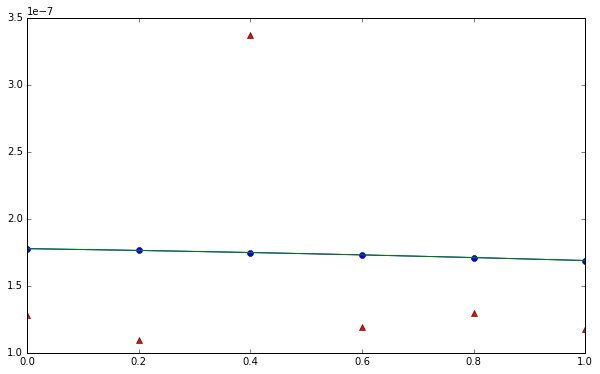

[ 0.16666667  0.5         0.83333333]


In [24]:
"""
Visualizing the result
"""
Dx_ = np.empty((40,N))
for k in range(40):
	Dx_[k,:] = (x[k] - xc)

phi_m = phi(Dx, sig)
u = np.dot(phi_m, c)
plt.figure(figsize=(10,6))
plt.plot(xe, u, 'bo', xe, u, xe, f(xe), 'r^')

phi_m_ = phi(Dx_, sig)
u_ = np.dot(phi_m_, c)
print(phi_m.shape)
print(x.shape)
print(u.shape)
plt.plot(x, u_)
plt.show()
print(xc)

In [13]:
F(X)

array([ 1.33732467, -3.2533499 ,  1.08224583,  0.82813551, -0.06019185,
       -0.11609308])

- bc
- 2 gaussianas
- distinto solver |F|
- well posedeness